# Введение в квантование моделей

Проблема - LLM могут быть очень большими, хочется снизить количество потребляемой памяти.

Что делать? Квантовать!


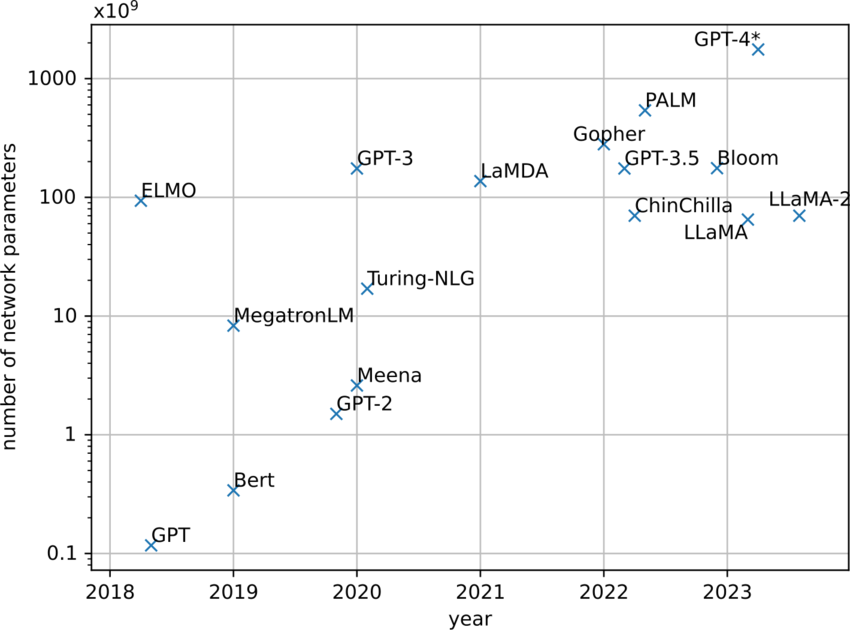

Самый простой способ уменьшить потребление памяти - перевести веса модели в другой тип. Например, из float32 в float16/bfloat16.

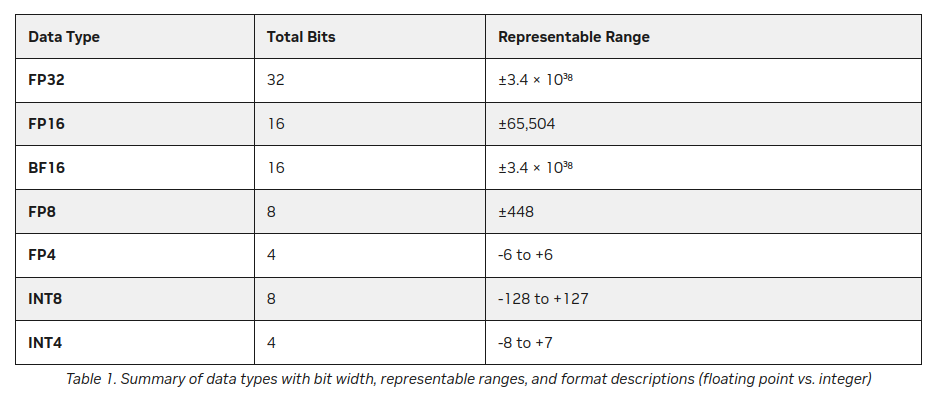

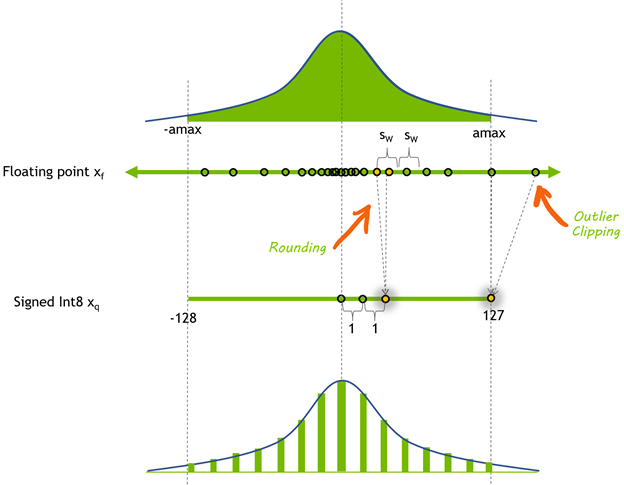

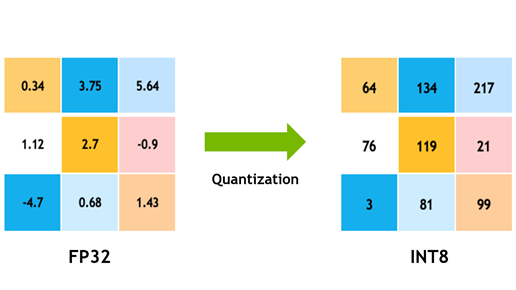

Помимо изменения размера, применяется так же изменение представления числа с плавающей точкой (см. следующий рисунок). Например, float16 -> bfloat16.

Основное отличие между float16 и bfloat16 заключается в распределении битов: float16 использует 5 бит для экспоненты и 10 бит для мантиссы, что обеспечивает высокую точность, но малый динамический диапазон, тогда как bfloat16 сохраняет 8 бит экспоненты (как у float32) и только 7 бит мантиссы, что обеспечивает почти такой же динамический диапазон как float32 но меньшую точность.

Соответственно, этот тип позволяет уменьшит количество памяти в два раза, при этом сохранив диапазон float32, обеспечивая стабильность вычслений больших значений.

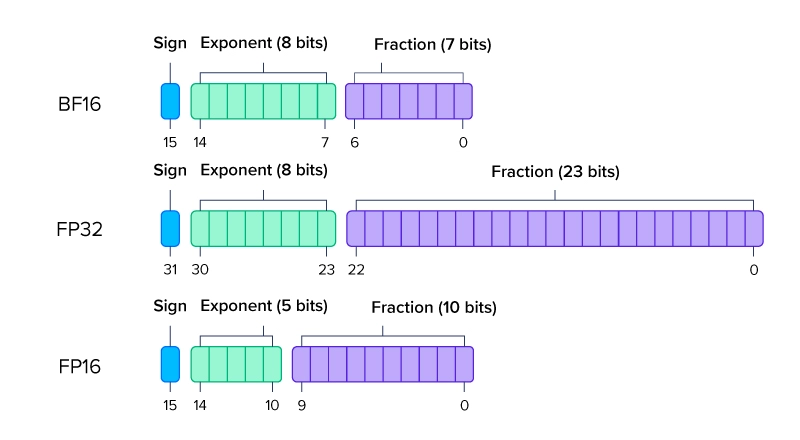

Формат хранения квантованных весов - GGUF.

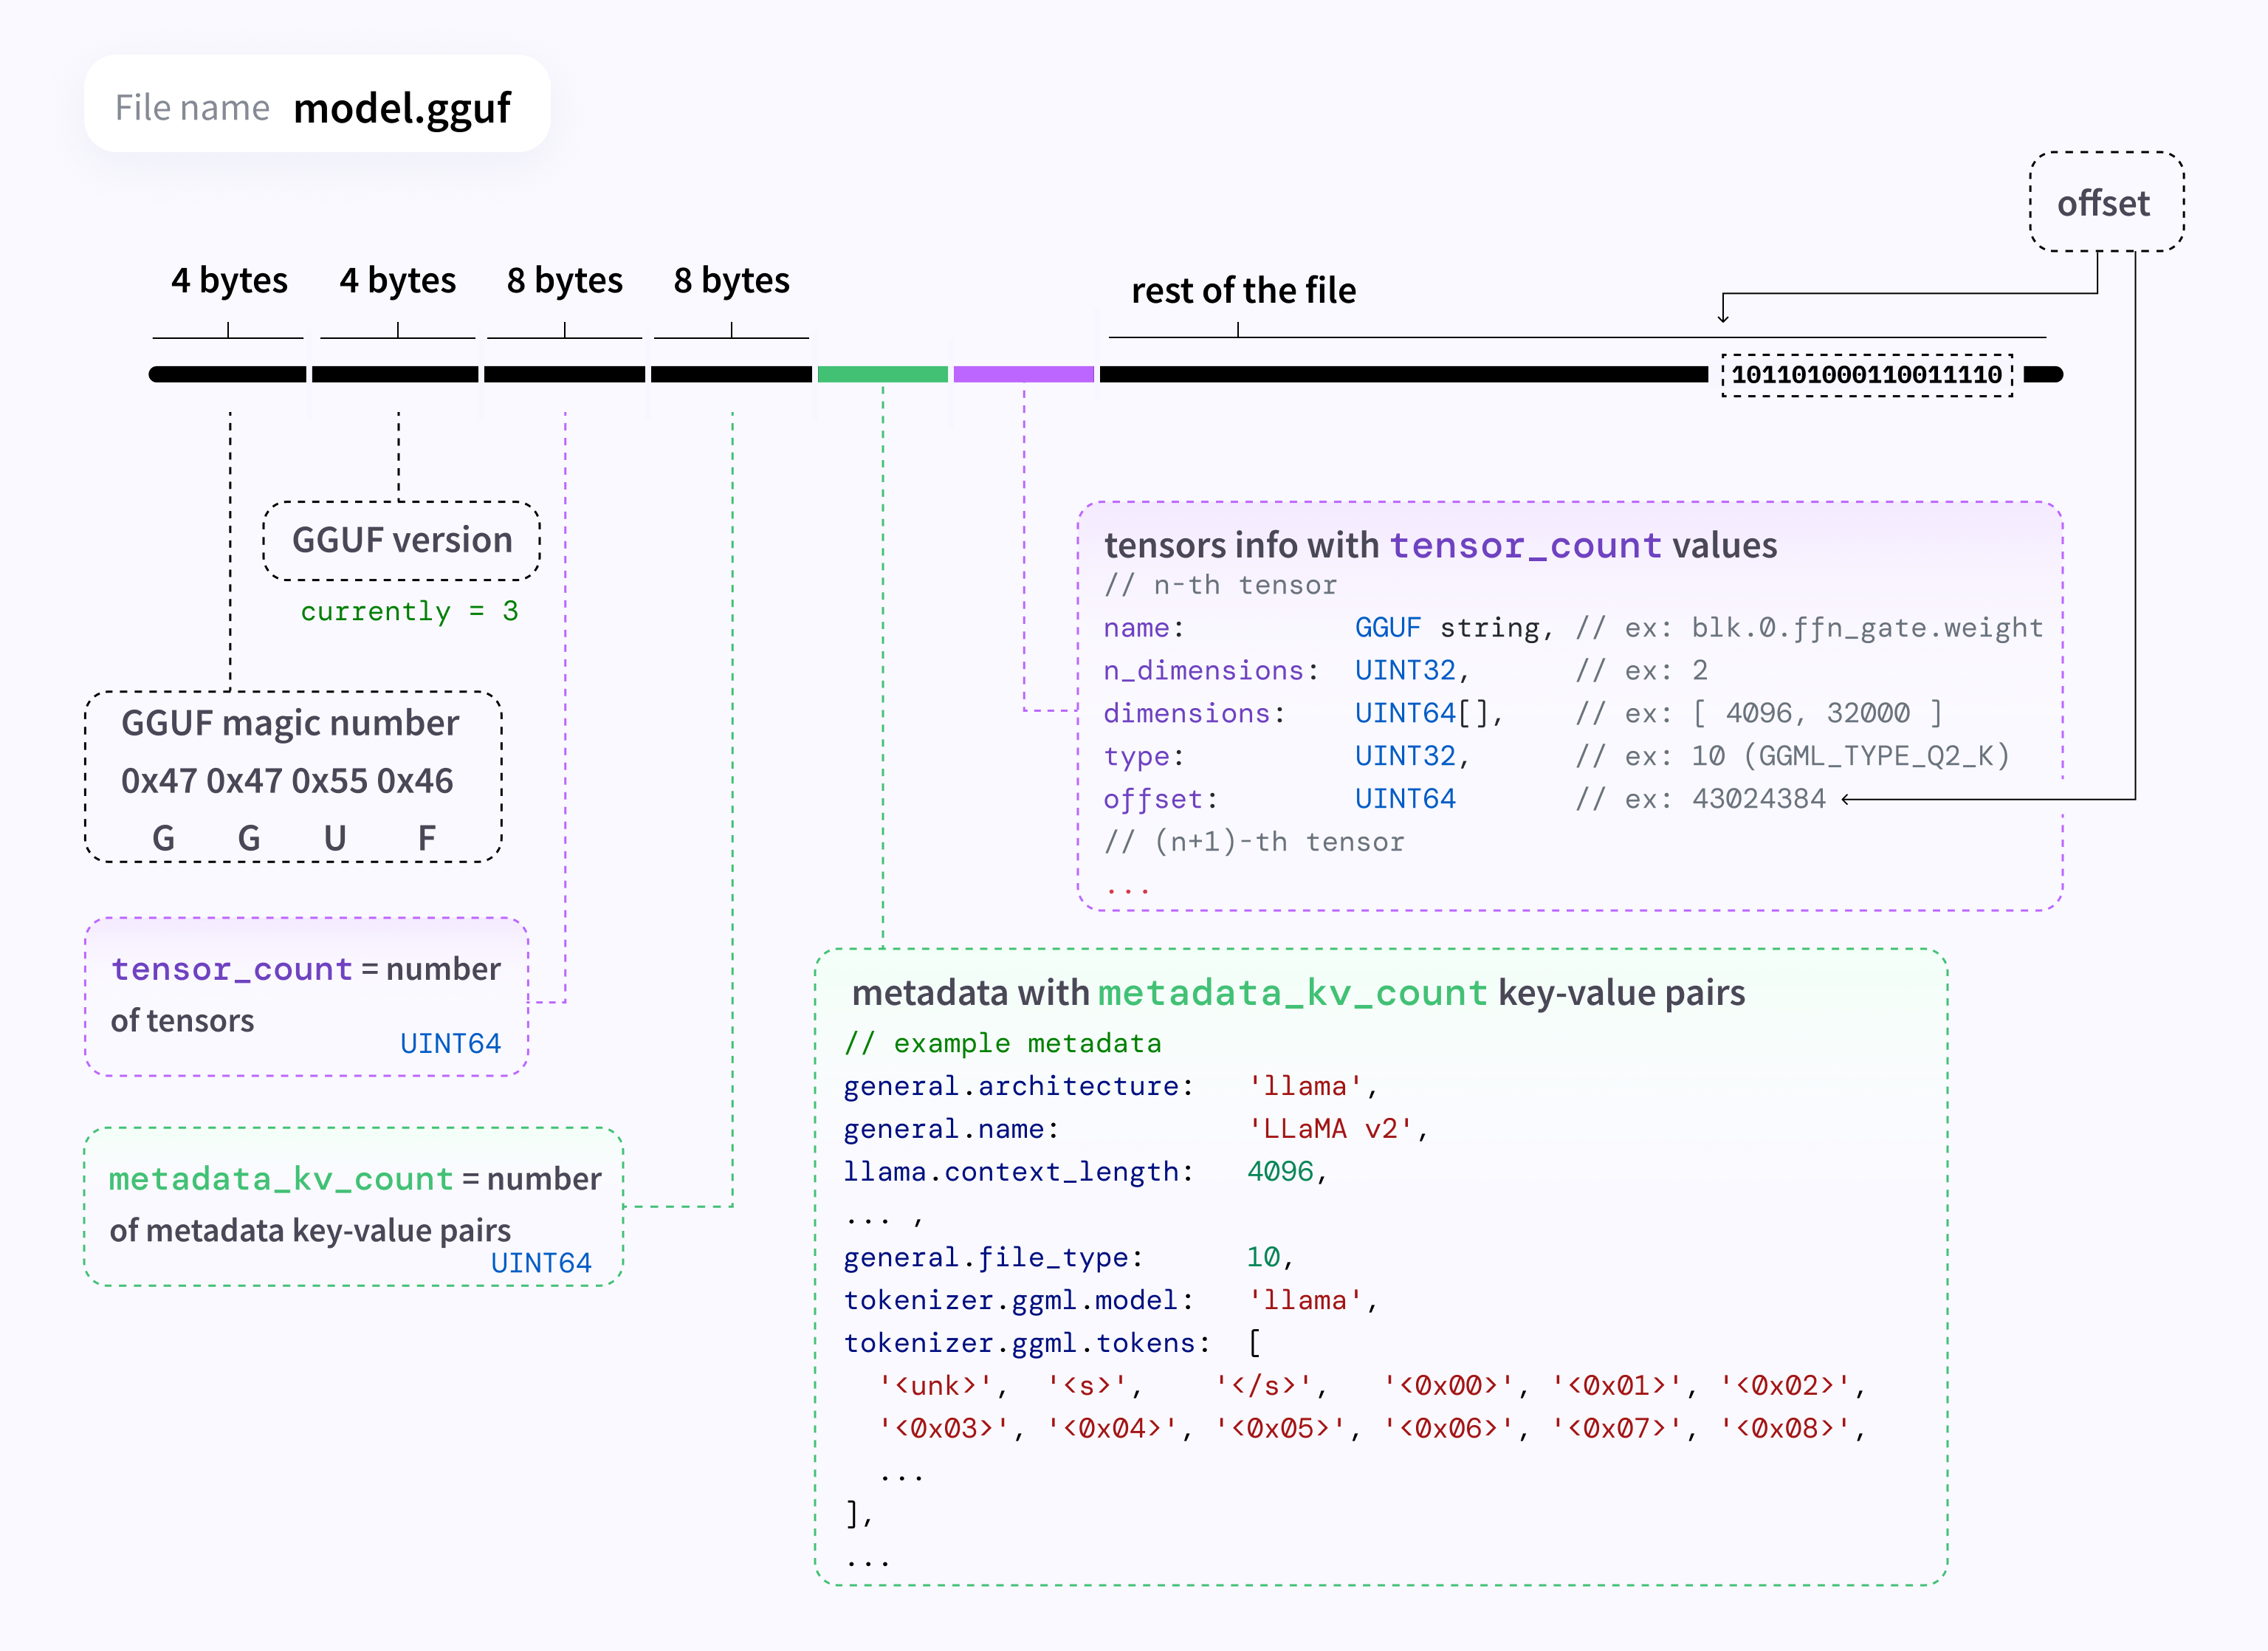

### Пример простого квантования

### Пробуем bitsabdbytes
Bitsandbyes: https://huggingface.co/docs/bitsandbytes/main/index

In [ ]:
%pip install torch transformers accelerate bitsandbytes

In [ ]:
import torch
import torch.nn as nn

from bitsandbytes.nn import Linear4bit

fp16_model = nn.Sequential(
    nn.Linear(64, 64),
    nn.Linear(64, 64)
)

quantized_model = nn.Sequential(
    Linear4bit(64, 64),
    Linear4bit(64, 64)
)

quantized_model.load_state_dict(fp16_model.state_dict())
quantized_model = quantized_model.to(0)

In [ ]:
quantized_model[0]._parameters

### Загрузим модель в обычном fp16

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import bitsandbytes
import psutil
import gc


MODEL_NAME = "Qwen/Qwen3-0.6B"
torch.cuda.empty_cache()
gc.collect()

model_fp16 = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16,
    device_map="auto"
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

messages = [
    {"role": "user", "content": "Tell me about context-free grammar"},
]

text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True,
    enable_thinking=False
)
model_inputs = tokenizer([text], return_tensors="pt").to(model_fp16.device)

generated_ids = model_fp16.generate(
    **model_inputs,
    max_new_tokens=32768
)
output_ids = generated_ids[0][len(model_inputs.input_ids[0]):].tolist()

content = tokenizer.decode(output_ids, skip_special_tokens=True).strip("\n")
print(content)


A **context-free grammar (CFG)** is a type of **context-sensitive grammar** that does **not** require a **context** to determine the correct parse. It is characterized by the fact that the **nonterminal symbols** (which are the ones that generate other non-terminal symbols) are not bound by any specific context. Instead, the **production rules** (which define how non-terminals are replaced with terminals or other non-terminals) are used to construct the grammar.

### Key Features:
- **No context** is required to determine the correct parse.
- Non-terminals can be replaced by terminals or other non-terminals.
- The grammar is **unambiguous** in terms of parsing.
- It is **universal** in the sense that it can generate any finite string, provided it is in the language of the grammar.

### Example:
A simple CFG:
```
S → a b
a → a
b → b
```

### Applications:
- Parsing programs.
- Building compilers and interpreters.
- Syntax analysis.

### Notation:
A CFG can be represented using a **produ

### Попробуем сквантованную модель (в 8 бит)

In [ ]:
quantization_config = BitsAndBytesConfig(
    load_in_8bit=True,
)

model_8_bit = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=quantization_config,
    device_map="auto",
    trust_remote_code=True
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

messages = [
    {"role": "user", "content": "Tell me about context-free grammar"},
]

text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True,
    enable_thinking=False
)
model_inputs = tokenizer([text], return_tensors="pt").to(model_8_bit.device)

generated_ids = model_8_bit.generate(
    **model_inputs,
    max_new_tokens=32768
)
output_ids = generated_ids[0][len(model_inputs.input_ids[0]):].tolist()

content = tokenizer.decode(output_ids, skip_special_tokens=True).strip("\n")
print(content)

A **context-free grammar (CFG)** is a type of **context-free formal grammar** that does **not** require a **context** (i.e., a particular context or a dependency) to be specified in its productions. This means that a grammar can be used to generate **strings** without needing to specify the context or the way the string is formed.

### Key Features of a Context-Free Grammar:
1. **No context dependency**: The production rules do not depend on the position of the input string in the context. For example, a rule like `A → B C` can generate any string that ends with `C` and starts with `B`, regardless of where the string is located.

2. **Generates strings**: CFGs are used to generate **strings** (or words) from a set of rules. These rules can be used to build the entire string from a starting symbol.

3. **Not a dependency**: Unlike a **context-sensitive grammar**, CFGs do **not** have dependencies. This is why they are called **context-free**.

### Examples of Context-Free Grammars:
- **

Другие типы: https://huggingface.co/docs/hub/gguf#quantization-types

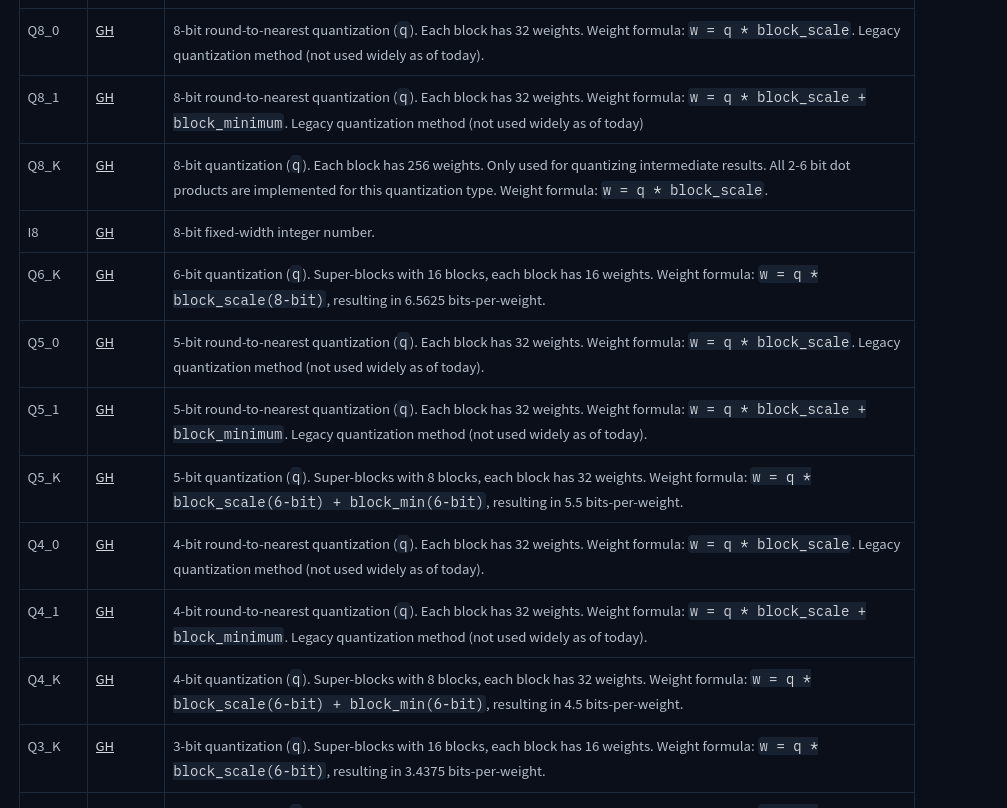

Вопрос: а какие проблемы есть у такого подхода к квантизации?

### А есть ли что-то получше?

Такой тип квантования - "глупый". Мы знаем, что не все веса одинакво важны. Хочется наиболее важные веса не "ужимать". Что делать? Умное квантование!

Один из таких алгоритмов - GPTQ. В отличие от простого округления весов, GPTQ квантует модель послойно, используя калибровочный датасет и алгоритм второго порядка, который компенсирует ошибки квантования одних весов за счет корректировки других.

Основная концепция - найти такие квантованные веса, чтобы получаемые активации не сильно отличались от активаций после обычных весов.


L(w) = ‖ WX - ŴX ‖²

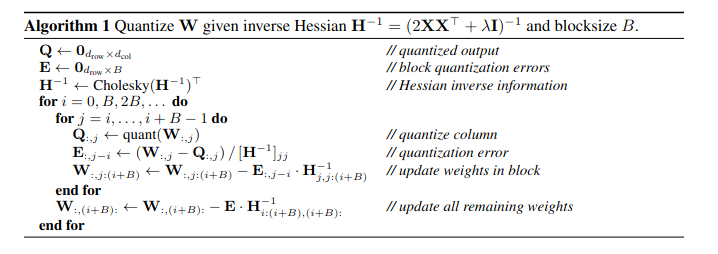



### Можно делать ещё умнее

AWQ (Activation-Aware Weight Quantization) - метод пост-тренировочного квантования, который защищает наиболее важные веса модели от агрессивного сжатия. Идея - давайте самые важные веса хранить в fp16, а остальное сквантуем в int8. Но так как вычисления в mixed precision не очень эффективно. Поэтому мы соберем статистику по калибровочному датасету, определим, какие веса наиболее важные (после каких весов активации высокие). Посчитаем калибровочные коэффициенты и будем использовать их для маштабирования весов перед квантованием.


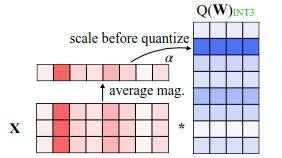


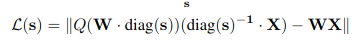




### Пример квантования через optimum

In [ ]:
!pip install optimum gptqmodel

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, GPTQConfig

# В учебных целях для ускорения возьмем opt-125m вместо Qwen-3-0.6B
tokenizer = AutoTokenizer.from_pretrained("facebook/opt-125m")
gptq_config = GPTQConfig(bits=8, dataset="c4", tokenizer=tokenizer)

In [ ]:
quantized_model = AutoModelForCausalLM.from_pretrained(
    "facebook/opt-125m",
    device_map="auto",
    quantization_config=gptq_config
)

### А через что еще можно квантовать? И как делать быстрый инференс?

Для этого используются llama.cpp и vllm, но об этом в следующих сериях